In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import mylibrary.datasets as datasets
import copy
%matplotlib inline

## Loading the dataset

In [7]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

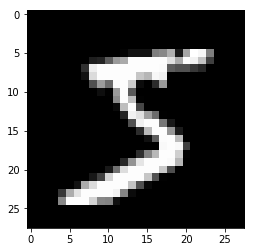

In [8]:
plt.imshow(train_data[0].reshape(28,28), cmap='gray')

In [9]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 64#300
EPOCHS = 10

train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label)

## Training a linear model

In [5]:
linear_regression = tnn.LinearLayer(input_size, output_size, optimizer=tnn.Adam())

accuracy_list = []
for epoch in range(EPOCHS):
    for index in range(train_size // batch_size):
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = linear_regression.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx = linear_regression.backward(dy)

        linear_regression.update()
        
        if index % 100 == 0:
            
            print('\nTRAIN',index, '-> ', loss)
            yout = linear_regression.forward(train_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(train_label_)).sum()

            accuracy = correct / len(train_label_) * 100.
            print('EPOCH = ',epoch,'accuracy = ', accuracy)
            print(correct, '/', len(train_label_))
            
            yout = linear_regression.forward(test_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(test_label_)).sum()

            accuracy = correct / len(test_label_) * 100.
            print('   TEST  ','accuracy = ', accuracy)
            print(correct, '/', len(test_label_))            


TRAIN 0 ->  6.4271752437895735
EPOCH =  0 accuracy =  17.988333333333333
10793 / 60000
   TEST   accuracy =  17.22
1722 / 10000

TRAIN 100 ->  5.771231139757187
EPOCH =  0 accuracy =  86.37833333333333
51827 / 60000
   TEST   accuracy =  87.22999999999999
8723 / 10000

TRAIN 200 ->  5.774312290250135
EPOCH =  0 accuracy =  87.47333333333333
52484 / 60000
   TEST   accuracy =  87.97
8797 / 10000

TRAIN 300 ->  5.769567095356269
EPOCH =  0 accuracy =  90.03166666666667
54019 / 60000
   TEST   accuracy =  89.96
8996 / 10000

TRAIN 400 ->  5.815523076987942
EPOCH =  0 accuracy =  88.03833333333333
52823 / 60000
   TEST   accuracy =  88.02
8802 / 10000

TRAIN 500 ->  5.77486719547034
EPOCH =  0 accuracy =  87.43166666666666
52459 / 60000
   TEST   accuracy =  87.82
8782 / 10000

TRAIN 600 ->  5.796560758767783
EPOCH =  0 accuracy =  86.17
51702 / 60000
   TEST   accuracy =  85.97
8597 / 10000

TRAIN 700 ->  5.808956841115238
EPOCH =  0 accuracy =  88.83166666666666
53299 / 60000
   TEST   

KeyboardInterrupt: 

## Creating a Soft Decision Tree classes

In [47]:
class LeafNode(object):
    
    def __init__(self, input_dim, output_dim, learning_rate=0.0001):
        self.fc = tnn.LinearLayer(input_dim, output_dim, optimizer=tnn.Adam(learning_rate))
        self.prob = None
        self.del_outputs = None
        self.del_prob = None
        
    def forward(self, inputs):
        fc_out = self.fc.forward(inputs)
        return fc_out
    
    def backward(self, del_outputs):
        self.del_outputs = del_outputs
        del_inputs = self.fc.backward(del_outputs)
        return del_inputs
    
    def update(self):
        self.fc.update()
        

class InnerNode(object):
    
    def __init__(self, input_dim, output_dim, learning_rate=0.0001):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.fc = tnn.NonLinearLayer(input_dim, 1, activation=tnn.Sigmoid(), optimizer=tnn.Adam(learning_rate))
        self.probs = None
        self.left = None
        self.right = None
        
        self.prob_left = None
        self.prob_right = None
        
        self.out_left = None
        self.out_right = None
        return
    
    def create_child(self, depth):
        if depth > 1:
            self.left = InnerNode(self.input_dim, self.output_dim, self.learning_rate)
            self.right = InnerNode(self.input_dim, self.output_dim, self.learning_rate)
            self.left.create_child(depth-1)
            self.right.create_child(depth-1)
        else:
            self.left = LeafNode(self.input_dim, self.output_dim, self.learning_rate)
            self.right = LeafNode(self.input_dim, self.output_dim, self.learning_rate)

    
    def forward(self, inputs):
        self.probs = self.fc.forward(inputs)
        self.prob_left = self.probs
        self.prob_right = (1-self.probs)        
        
        self.out_left = self.left.forward(inputs)
        self.out_right = self.right.forward(inputs)
        
        output = self.out_left*self.prob_left + self.out_right*self.prob_right
        return output
    
    def backward(self, del_outputs):
        del_out_left = del_outputs*self.prob_left
        del_out_right = del_outputs*self.prob_right

        del_inp_left = self.left.backward(del_out_left)
        del_inp_right = self.right.backward(del_out_right)
        
        del_prob_left = np.mean(self.out_left*del_outputs, axis=1, keepdims=True)
        del_prob_right = np.mean(self.out_right*del_outputs, axis=1, keepdims=True)
        
        del_probs = (del_prob_left - del_prob_right)
        del_inp_probs = self.fc.backward(del_probs)
        
        del_inputs = del_inp_left + del_inp_right + del_inp_probs
        
        return del_inputs
        
        
    def update(self):
        self.fc.update()
        self.left.update()
        self.right.update()
        
    def harden_decision(self, magnitude):
        factor = magnitude/np.linalg.norm(self.fc.weights)
        self.fc.weights = self.fc.weights * factor
        self.fc.bias = self.fc.bias * factor
        
        if type(self.left) == InnerNode:
            self.left.harden_decision(magnitude)
        if type(self.right) == InnerNode:
            self.right.harden_decision(magnitude)
            
    def forward_hard(self, inputs):
        self.probs = self.fc.forward(inputs)
        
        self.prob_left = self.probs>0.5
        self.prob_right = ~self.prob_left        
        
        if type(self.left) == InnerNode:
            self.out_left = self.left.forward_hard(inputs)
            self.out_right = self.right.forward_hard(inputs)
        else:
            self.out_left = self.left.forward(inputs)
            self.out_right = self.right.forward(inputs)
            
        output = self.out_left*self.prob_left + self.out_right*self.prob_right
        return output

### Training Soft Decision Tree

In [48]:
tree_depth = 3
sdt = InnerNode(input_size, output_size)
sdt.create_child(tree_depth)

In [49]:
learning_rate = 0.0001
batch_size = 64#300
EPOCHS = 20

accuracy_list = []
# magnitude = 0.
for epoch in range(EPOCHS):
    
#     sdt.harden_decision(np.power(10, magnitude/1000.))
    sdt.harden_decision(np.power(10, epoch/2))
    
    for index in range(train_size // batch_size):
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = sdt.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx = sdt.backward(dy)

        sdt.update()
#         magnitude += 1.
        if index % 100 == 0:
                        
            print('\nTRAIN',index, '-> ', loss)
            yout = sdt.forward(train_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(train_label_)).sum()

            accuracy = correct / len(train_label_) * 100.
            print('EPOCH = ',epoch,'accuracy = ', accuracy)
            print(correct, '/', len(train_label_))
            
            yout = sdt.forward(test_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(test_label_)).sum()

            accuracy = correct / len(test_label_) * 100.
            print('   TEST  ','accuracy = ', accuracy)
            print(correct, '/', len(test_label_))  
        



TRAIN 0 ->  6.460409913733963
EPOCH =  0 accuracy =  12.606666666666666
7564 / 60000
   TEST   accuracy =  12.29
1229 / 10000

TRAIN 100 ->  6.2255978327248185
EPOCH =  0 accuracy =  66.95166666666667
40171 / 60000
   TEST   accuracy =  67.19000000000001
6719 / 10000

TRAIN 200 ->  6.142939572651649
EPOCH =  0 accuracy =  78.815
47289 / 60000
   TEST   accuracy =  79.22
7922 / 10000

TRAIN 300 ->  5.9831559071003095
EPOCH =  0 accuracy =  82.93833333333333
49763 / 60000
   TEST   accuracy =  83.73
8373 / 10000

TRAIN 400 ->  5.975910216659272
EPOCH =  0 accuracy =  85.40166666666667
51241 / 60000
   TEST   accuracy =  86.02
8602 / 10000

TRAIN 500 ->  5.932855648281015
EPOCH =  0 accuracy =  86.38333333333334
51830 / 60000
   TEST   accuracy =  87.39
8739 / 10000

TRAIN 600 ->  5.933989233400958
EPOCH =  0 accuracy =  87.32666666666667
52396 / 60000
   TEST   accuracy =  88.32
8832 / 10000

TRAIN 700 ->  5.993379208189727
EPOCH =  0 accuracy =  87.84166666666667
52705 / 60000
   TEST 

EPOCH =  6 accuracy =  93.69833333333332
56219 / 60000
   TEST   accuracy =  93.42
9342 / 10000

TRAIN 500 ->  5.772127682918013
EPOCH =  6 accuracy =  93.72833333333334
56237 / 60000
   TEST   accuracy =  93.33
9333 / 10000

TRAIN 600 ->  5.756044439651488
EPOCH =  6 accuracy =  93.75
56250 / 60000
   TEST   accuracy =  93.4
9340 / 10000

TRAIN 700 ->  5.778725978836468
EPOCH =  6 accuracy =  93.80166666666668
56281 / 60000
   TEST   accuracy =  93.13
9313 / 10000

TRAIN 800 ->  5.760138435516247
EPOCH =  6 accuracy =  93.91833333333334
56351 / 60000
   TEST   accuracy =  93.4
9340 / 10000

TRAIN 900 ->  5.78850310435516
EPOCH =  6 accuracy =  93.88166666666666
56329 / 60000
   TEST   accuracy =  93.28
9328 / 10000

TRAIN 0 ->  5.711437056787716
EPOCH =  7 accuracy =  93.83666666666667
56302 / 60000
   TEST   accuracy =  93.31
9331 / 10000

TRAIN 100 ->  5.723356541081421
EPOCH =  7 accuracy =  93.89166666666667
56335 / 60000
   TEST   accuracy =  93.23
9323 / 10000

TRAIN 200 ->  5.7

KeyboardInterrupt: 

In [46]:
a = np.sort(np.abs(sdt.fc.bias))
a.min(), a.max()

(0.008149207475408347, 0.008149207475408347)

## Hard forward

In [40]:
yout = sdt.forward_hard(test_data)
outputs = tnn.Logits.logit_to_index(yout)
correct = (outputs == np.array(test_label_)).sum()

accuracy = correct / len(test_label_) * 100.
print('   TEST  ','accuracy = ', accuracy)
print(correct, '/', len(test_label_))  

   TEST   accuracy =  69.98
6998 / 10000


## Cyclic hardening and softening

In [28]:
tree_depth = 3
sdt = InnerNode(input_size, output_size)
sdt.create_child(tree_depth)

In [32]:
learning_rate = 0.0001
batch_size = 64#300
EPOCHS = 20

accuracy_list = []
for epoch in range(EPOCHS):
            
    mag = np.power(10,epoch%5)
    sdt.harden_decision(mag)
    
    for index in range(train_size // batch_size):
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = sdt.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx = sdt.backward(dy)

        sdt.update()
        if index % 100 == 0:
                        
            print('\nTRAIN',index, '-> ', loss)
            yout = sdt.forward(train_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(train_label_)).sum()

            accuracy = correct / len(train_label_) * 100.
            print('EPOCH = ',epoch,'accuracy = ', accuracy)
            print(correct, '/', len(train_label_))
            
            yout = sdt.forward(test_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(test_label_)).sum()

            accuracy = correct / len(test_label_) * 100.
            print('   TEST  ','accuracy = ', accuracy)
            print(correct, '/', len(test_label_))  


TRAIN 0 ->  5.725549654104375
EPOCH =  0 accuracy =  95.70166666666667
57421 / 60000
   TEST   accuracy =  95.03
9503 / 10000

TRAIN 100 ->  5.706615283101673
EPOCH =  0 accuracy =  95.98166666666667
57589 / 60000
   TEST   accuracy =  95.35
9535 / 10000

TRAIN 200 ->  5.715495697081224
EPOCH =  0 accuracy =  96.11666666666666
57670 / 60000
   TEST   accuracy =  95.45
9545 / 10000

TRAIN 300 ->  5.705844467219088
EPOCH =  0 accuracy =  96.25166666666667
57751 / 60000
   TEST   accuracy =  95.50999999999999
9551 / 10000

TRAIN 400 ->  5.690039003738425
EPOCH =  0 accuracy =  96.34333333333333
57806 / 60000
   TEST   accuracy =  95.63000000000001
9563 / 10000

TRAIN 500 ->  5.731642387069918
EPOCH =  0 accuracy =  96.45166666666667
57871 / 60000
   TEST   accuracy =  95.8
9580 / 10000

TRAIN 600 ->  5.689939288926043
EPOCH =  0 accuracy =  96.43
57858 / 60000
   TEST   accuracy =  95.67999999999999
9568 / 10000

TRAIN 700 ->  5.752874918363013
EPOCH =  0 accuracy =  96.5
57900 / 60000
 

In [35]:
np.linalg.norm(sdt.fc.weights)

10000.000000124475